In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/noise2noise

Mounted at /content/drive
/content/drive/MyDrive/noise2noise


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip3 install -e . -q
!pip3 install nbdev -q

     |████████████████████████████████| 49 kB 2.2 MB/s 
     |████████████████████████████████| 561 kB 10.5 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 60 kB 6.1 MB/s 
     |████████████████████████████████| 133 kB 44.8 MB/s 
     |████████████████████████████████| 130 kB 44.4 MB/s 
     |████████████████████████████████| 428 kB 45.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.0.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!nbdev_build_lib

In [3]:
from noise2noise.training import *
from noise2noise.unet import *
from noise2noise.helpers import *
from noise2noise.augmentation import *

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

training_img, training_target = load_images()
mean, std = to_float_image(training_img).mean(dim=(0,2,3)), to_float_image(training_img).std(dim=(0,2,3))
input_transform = transforms.Compose([ToFloatImage(), transforms.Normalize(mean =mean, std = std)])

target_transform = transforms.Compose([ToFloatImage()])

In [4]:
train_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/train_data.pkl', 
                       transform=input_transform, 
                       target_transform=target_transform,
                       input_target_transforms = RandomResizedCrop()),
    batch_size = 64,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

test_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/val_data.pkl', transform=input_transform, target_transform=target_transform),
    batch_size = 64,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

In [19]:
unet = UnetBatchNorm().to(device)
optim = Adam(unet.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.975)
metric = psnr_metric()
criterion = nn.MSELoss()




train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=2000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=100)

100%|██████████| 2000/2000 [01:27<00:00, 22.91it/s]


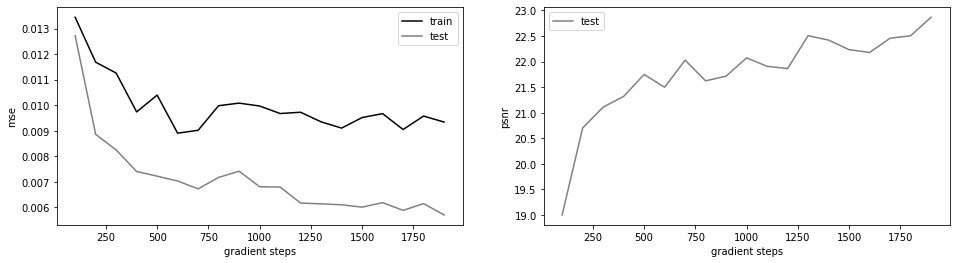

In [13]:
plot_losses(train_loss, test_loss, test_metric)

psnr :21.775550842285156
psnr :20.368330001831055
psnr :23.825916290283203
psnr :25.332923889160156


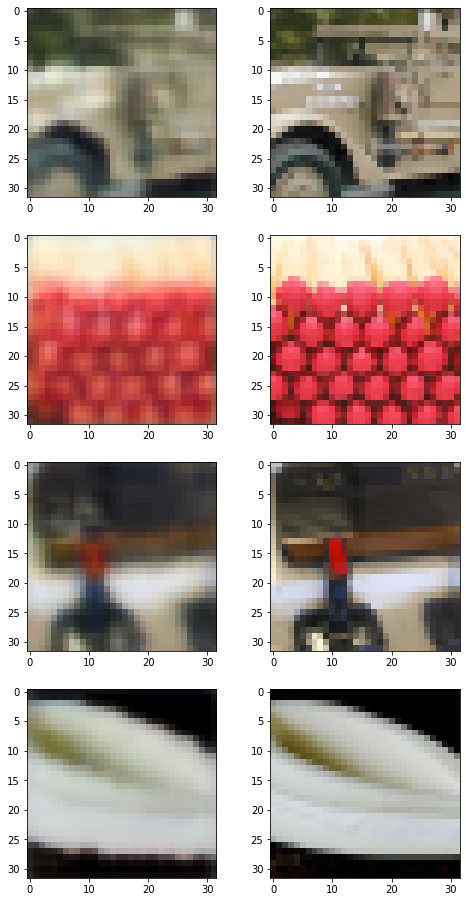

In [21]:
show_results(unet, test_loader)

In [ ]:
train_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/train_data.pkl', 
                       transform=input_transform, 
                       target_transform=target_transform,
                       input_target_transforms = RandomRotation()),
    batch_size = 64,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

/usr/lib/python3.7/json/encoder.py:257: UserWarning: date_default is deprecated since jupyter_client 7.0.0. Use jupyter_client.jsonutil.json_default.
  return _iterencode(o, 0)


In [15]:
unet = UnetBatchNorm().to(device)
optim = Adam(unet.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.975)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, 1e-2, total_steps=2000)
metric = psnr_metric()
criterion = nn.MSELoss()




train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=2000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=200)

100%|██████████| 2000/2000 [01:27<00:00, 22.75it/s]


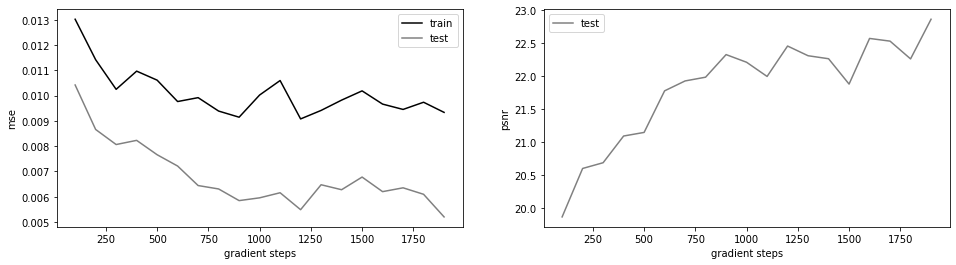

In [16]:
plot_losses(train_loss, test_loss, test_metric)

psnr :20.59707260131836
psnr :23.58539390563965
psnr :24.263551712036133
psnr :23.727127075195312


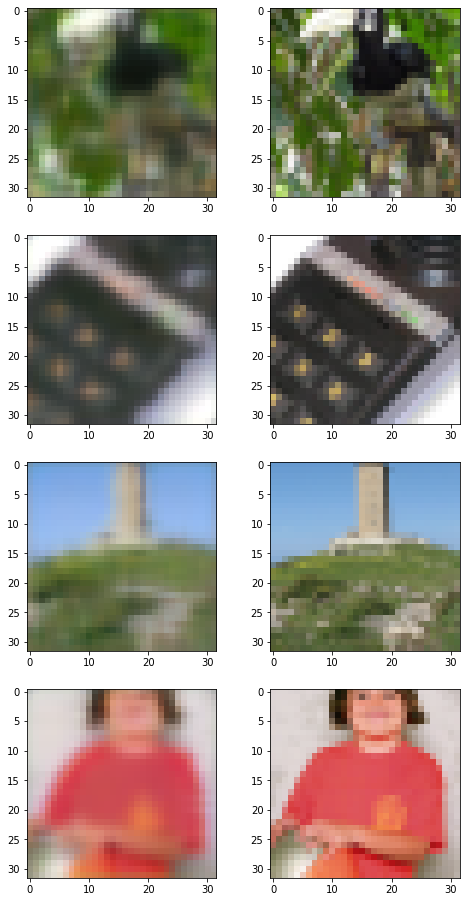

In [18]:
show_results(unet, test_loader)